In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import time

# Utils

In [ ]:
def permute_uid(df, seed):
    users = df.uid.unique()
    np.random.seed(seed)
    np.random.shuffle(users)
    perm_df = pd.DataFrame(columns=df.columns)
    for i in users:
        perm_df = perm_df.append(df[df['uid']==i])
    return perm_df.reset_index(drop=True).copy()

In [ ]:
def traj_percentage(df, p=100):
    return df[df.tid.isin(                                                  
                [df_train[df_train.uid==i].tid.unique()[j]                  
                 for i in df_train.uid.unique() 
                 for j in range(
                     int(p/100*len(df_train[df_train.uid==i].tid.unique())))
                 ])].reset_index(drop=True).copy()

In [ ]:
from tensorflow.keras.layers import CategoryEncoding
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preproc_trajgan(df_train, df_test):
  df_train, df_test = df_train.copy(), df_test.copy()

  data = [df_train, df_test]
  df = pd.concat([df_train, df_test], ignore_index=True, copy=False) # just for checking

  # Dict for sizes
  vocab_sizes = {i:df[i].unique().size for i in df.columns[:]}
  vocab_sizes['max_len'] = df.groupby('tid').count().max()[0]
#   print(vocab_sizes)
  vocab_sizes['lat_lon'] = 2

  # Dict for encoding
  vocab_encod = {}
  for j in df.columns[-3:]:
    vocab_encod[j] = {sorted(df[j].unique())[i]:i for i in range(df[j].unique().size)} 

  # Dict for coords centroids
  vocab_centroid = {}
  vocab_centroid['lat'] = df['lat'].mean()
  vocab_centroid['lon'] = df['lon'].mean()
  vocab_centroid['scale']  = max(abs(df['lat'].min() - vocab_centroid['lat']),
                                 abs(df['lat'].max() - vocab_centroid['lat']),
                                 abs(df['lon'].min() - vocab_centroid['lon']),
                                 abs(df['lon'].min() - vocab_centroid['lon']))

  # Replace with dict for encoding 
  for d in data:
    for j in df.columns[-3:]:
      d[j] = d[j].replace(to_replace=vocab_encod[j])
    # Coords
    d['lat'] = d['lat'] - vocab_centroid['lat']
    d['lon'] = d['lon'] - vocab_centroid['lon']
    d['lat_lon'] = [(d['lat'][i], d['lon'][i]) for i in range(d.shape[0])]
    # Mask
    d['mask'] = [1 for _ in range(d.shape[0])] 

  # Re-format datasets
  col = ['tid', 'lat_lon', 'day', 'hour', 'poi', 'mask']
  df_train = df_train[col]
  df_test = df_test[col]

  # Lists for storing column data
  train = [[] for i in range(len(col))]
  test = [[] for i in range(len(col))]

  # Encoding 
  for i in df_train.tid.unique():
    for j, key in enumerate(col):
      if key in ['tid', 'lat_lon', 'mask']:
        train[j].append(df_train[df_train.tid==i].iloc[:,j].to_numpy()) 
      else:
        train[j].append(
            CategoryEncoding(num_tokens=vocab_sizes[key], output_mode="one_hot")
            (df_train[df_train.tid==i].iloc[:,j].to_numpy()).numpy()
            )   
        
  for i in df_test.tid.unique():
    for j, key in enumerate(col):
      if key in ['tid', 'lat_lon', 'mask']:
        test[j].append(df_test[df_test.tid==i].iloc[:,j].to_numpy())
      else:
        test[j].append(
            CategoryEncoding(num_tokens=vocab_sizes[key], output_mode="one_hot")
            (df_test[df_test.tid==i].iloc[:,j].to_numpy()).numpy()
            )
    
  # Reformat latlon to match other features
  for t in [train, test]:
    t[1] = np.array([np.array([i for i in j]) for j in t[1]], dtype=object)


  train_x = np.array(train[1:], dtype=object)
  test_x = np.array(test[1:], dtype=object)

  # Print Informations 
  print('Trajectories:  ', df.tid.unique().size)
  print('Labels:        ', df.uid.unique().size)
  print('Train size:    ', len(train[0]) / df.tid.unique().size)
  print('Test size:     ', len(test[0]) / df.tid.unique().size)
  print('x_train shape: ', np.array(train_x, dtype=object).shape)
  # print('y_train shape: ', np.array(train[0], dtype=object).shape)
  print('x_test shape:  ', np.array(test_x, dtype=object).shape)
  # print('y_test shape:  ', np.array(test[0], dtype=object).shape)

  # Pad input sequences 
  train_x = [pad_sequences(f, vocab_sizes['max_len'], dtype='float32', padding='pre') for f in train_x]
  test_x = [pad_sequences(f,vocab_sizes['max_len'], dtype='float32', padding='pre') for f in test_x]

  return train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid


def postproc_trajgan(data_gen, df_real):
  df_real = df_real.copy()

  # Gen Data
  traj_attr_concat_list = []
  for attributes in data_gen:
      traj_attr_list = []
      for row in attributes:
          if row.shape[-1] == 2:
              traj_attr_list.append(row)          
          else:
              traj_attr_list.append(np.argmax(row, axis=-1))
      traj_attr_concat = np.concatenate(traj_attr_list)
      traj_attr_concat_list.append(traj_attr_concat)

  traj_data = np.column_stack((traj_attr_concat_list))
  
  # Create pandas data frame
  df_data_gen = pd.DataFrame(traj_data)
  df_data_gen.columns = ['lat','lon','day', 'hour', 'poi']
  # Cut padding 
  idx = 0
  for i in df_real.groupby('tid').size():
    df_data_gen = df_data_gen.drop(labels=range(idx,idx+vocab_sizes['max_len']-i), axis=0)
    idx += vocab_sizes['max_len']
  df_data_gen.reset_index(inplace=True, drop=True)
  # Convert location deviation to longtitude and latitude
  df_data_gen['lat'] = df_data_gen['lat'] + vocab_centroid['lat']
  df_data_gen['lon'] = df_data_gen['lon'] + vocab_centroid['lon']
  # Set right type
  df_data_gen['day'] = df_data_gen['day'].astype(np.int64)
  df_data_gen['hour'] = df_data_gen['hour'].astype(np.int64)
  df_data_gen['poi'] = df_data_gen['poi'].astype(np.int64)

  # replace hour and poi values 
  df_data_gen.day = df_data_gen.day.replace(to_replace={v: k for k, v in vocab_encod['day'].items()}) # reversed dict
  df_data_gen.hour = df_data_gen.hour.replace(to_replace={v: k for k, v in vocab_encod['hour'].items()}) # reversed dict
  df_data_gen.poi = df_data_gen.poi.replace(to_replace={v: k for k, v in vocab_encod['poi'].items()}) # reversed dict
  # Add uid and tid from real
  df_data_gen['uid'] = df_real['uid']
  df_data_gen['tid'] = df_real['tid']
  df_data_gen = df_data_gen[['uid','tid','lat','lon','day','hour','poi']]

  return df_data_gen

# Models

In [ ]:
# Discriminator Loss 
def d_bce_loss(y_true, y_pred, mask):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true[4], y_pred[4])
# Generator Loss
def g_traj_loss(y_true, y_pred, mask):
    traj_len = np.sum(mask, axis=1)

    # define losses
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    bce = tf.keras.losses.BinaryCrossentropy()
    cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    # Divide all features 
    t_latlon, t_day, t_hour, t_poi, t_dis = y_true[0], y_true[1], y_true[2], y_true[3], y_true[4]
    p_latlon, p_day, p_hour, p_poi, p_dis = y_pred[0], y_pred[1], y_pred[2], y_pred[3], y_pred[4]
    # Compute separately
    mse_latlon = tf.reduce_sum(tf.reduce_sum(mse(t_latlon, p_latlon) * mask, axis=-1) / traj_len) /256
    cce_day = tf.reduce_sum(tf.reduce_sum(cce(t_day, p_day) * mask, axis=-1) / traj_len) /256
    cce_hour = tf.reduce_sum(tf.reduce_sum(cce(t_hour, p_hour) * mask, axis=-1) / traj_len) /256
    cce_poi = tf.reduce_sum(tf.reduce_sum(cce(t_poi, p_poi) * mask, axis=-1) / traj_len) /256
    bce_dis = bce(t_dis, p_dis) 

    # Losses weights
    w_latlon, w_day, w_hour, w_poi, w_dis = 10, 1, 1, 1, 1

    return w_latlon*mse_latlon + w_day*cce_day + w_hour*cce_hour + w_poi*cce_poi + w_dis*bce_dis

def bce_acc(y_true, y_pred):
  bce = tf.keras.metrics.BinaryCrossentropy()
  return bce(y_true[4], y_pred[4])

In [ ]:
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, RepeatVector, concatenate, Lambda
from tensorflow.keras import Input, Model
from keras.initializers import he_uniform
from keras.regularizers import l1

class LSTM_TrajGAN():
    def __init__(self, latent_dim, vocab_sizes, vocab_centroid):
        
 
        self.vocab_sizes = vocab_sizes
        self.latent_dim = latent_dim
        self.scale = vocab_centroid['scale']
        
        # Define the optimizer
        self.optimizer = tf.keras.optimizers.Adam(0.001, 0.5)
        self.dropout = 0.0

        ## Build and compile the discriminator
        self.discriminator = self.build_discriminator()

        ## Build and compile the combined model (generator)
        self.generator = self.build_generator()

    def build_discriminator(self):
        
        # Inputs
        latlon = Input(shape=(vocab_sizes['max_len'], vocab_sizes['lat_lon']), name='input_latlon')
        wday = Input(shape=(vocab_sizes['max_len'], vocab_sizes['day']), name='input_day')
        hour = Input(shape=(vocab_sizes['max_len'], vocab_sizes['hour']), name='input_hour')
        poi = Input(shape=(vocab_sizes['max_len'], vocab_sizes['poi']), name='input_poi')

        all_inputs = [latlon, wday, hour, poi]

        # Embeddings
        latlon_emb = TimeDistributed(Dense(units=64, activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_latlon')(latlon)
        wday_emb = TimeDistributed(Dense(units=vocab_sizes['day'], activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_day')(wday)
        hour_emb = TimeDistributed(Dense(units=vocab_sizes['hour'], activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_hour')(hour)
        poi_emb = TimeDistributed(Dense(units=vocab_sizes['poi'], activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_poi')(poi)
        # Concatenate embeddings
        all_emb = concatenate(
            [latlon_emb,
            wday_emb,
            hour_emb,
            poi_emb])

        # Feature fusion layer
        fuse_traj = TimeDistributed(Dense(units=100, activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_traj')(all_emb)

        # LSTM Modeling Layer (many to many)
        x = LSTM(units=100, dropout=self.dropout, return_sequences=False, recurrent_regularizer=l1(0.02))(fuse_traj)

        # Outputs
        sigmoid = Dense(units=1, activation='sigmoid')(x) 

        # forward input for training generator with traj_loss
        all_outputs = [latlon, wday, hour, poi, sigmoid]

        # Model
        return tf.keras.Model(inputs=all_inputs, outputs=all_outputs, name='discriminator')

    def build_generator(self):      
        # Inputs
        latlon = Input(shape=(vocab_sizes['max_len'], vocab_sizes['lat_lon']), name='input_latlon')
        wday = Input(shape=(vocab_sizes['max_len'], vocab_sizes['day']), name='input_day')
        hour = Input(shape=(vocab_sizes['max_len'], vocab_sizes['hour']), name='input_hour')
        poi = Input(shape=(vocab_sizes['max_len'], vocab_sizes['poi']), name='input_poi')

        noise = Input(shape=(self.latent_dim,), name='input_noise')
        all_inputs = [latlon, wday, hour, poi, noise]

        # Embeddings
        latlon_emb = TimeDistributed(Dense(units=64, activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_latlon')(latlon)
        wday_emb = TimeDistributed(Dense(units=vocab_sizes['day'], activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_day')(wday)
        hour_emb = TimeDistributed(Dense(units=vocab_sizes['hour'], activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_hour')(hour)
        poi_emb = TimeDistributed(Dense(units=vocab_sizes['poi'], activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_poi')(poi)
        # Concatenate embeddings
        all_emb = concatenate(
            [latlon_emb,
            wday_emb,
            hour_emb,
            poi_emb])

        # Repeat noise for every vector and concatenate
        noise = RepeatVector(n=int(vocab_sizes['max_len']))(noise)
        all_emb = concatenate([all_emb, noise], axis=2)

        # Feature fusion layer
        fuse_traj = TimeDistributed(Dense(units=100, activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_traj')(all_emb)

        # LSTM Modeling Layer (many to many)
        x = LSTM(units=100, dropout=self.dropout, return_sequences=True, recurrent_regularizer=l1(0.02))(fuse_traj)

        # Outputs
        latlon_out = TimeDistributed(Dense(vocab_sizes['lat_lon'], activation='tanh'), name='output_latlon')(x)
        wday_out = TimeDistributed(Dense(vocab_sizes['day'], activation='softmax'), name='output_day')(x)
        hour_out = TimeDistributed(Dense(vocab_sizes['hour'], activation='softmax'), name='output_hour')(x)
        poi_out = TimeDistributed(Dense(vocab_sizes['poi'], activation='softmax'), name='output_poi')(x)
        # Stretched
        latlon_out = Lambda(lambda x: x * self.scale)(latlon_out)

        all_outputs = [latlon_out, wday_out, hour_out, poi_out]

        # Model
        return tf.keras.Model(inputs=all_inputs, outputs=all_outputs, name='generator')
        

    def train(self, data, epochs=2000, batch_size=256, sample_interval=10, save_path=None):
        
        X_train = data[:]

        # Array initialization for logging of the losses
        d_loss_logs_r = []
        d_loss_logs_f = []
        g_loss_logs = []
        d_acc_logs_r = []
        d_acc_logs_f = []
        g_acc_logs = []

        for epoch in range(1, epochs+1):

            # Select a random batch of trajectories
            idx = np.random.randint(0, X_train[0].shape[0], batch_size)
            real_trajs = []
            real_trajs.append(X_train[0][idx]) # latlon
            real_trajs.append(X_train[1][idx]) # day
            real_trajs.append(X_train[2][idx]) # hour
            real_trajs.append(X_train[3][idx]) # poi

            # mask
            mask = X_train[4][idx] 

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            real_trajs.append(noise)

            # Generate a batch of new trajs
            gen_trajs = self.generator.predict(real_trajs)

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # New labels including real traj [0-3] + class label [4]
            real_labels = real_trajs[:4] # no noise
            real_labels.append(np.ones((batch_size, 1)))
            fake_labels = gen_trajs[:]
            fake_labels.append(np.zeros((batch_size, 1)))

            # Train discriminator by customized loop considering only classification "true/fake"
            with tf.GradientTape() as tape:
                logits = self.discriminator(real_trajs[:4]) 
                d_loss_real = d_bce_loss(real_labels, logits, mask)
                d_acc_real = bce_acc(real_labels, logits)
            grads = tape.gradient(d_loss_real, self.discriminator.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            with tf.GradientTape() as tape:
                logits = self.discriminator(gen_trajs) 
                d_loss_fake = d_bce_loss(fake_labels, logits, mask)
                d_acc_fake = bce_acc(fake_labels, logits)
            grads = tape.gradient(d_loss_fake, self.discriminator.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_acc = 0.5 * np.add(d_acc_real, d_acc_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim)) # refresh noise?
            real_trajs[4] = noise

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = real_trajs[:4] # no noise
            valid_y.append(np.ones((batch_size, 1)))
            # print('g real len: ', len(valid_y))

            with tf.GradientTape() as tape:
                logits = self.discriminator(self.generator(real_trajs))
                g_loss = g_traj_loss(valid_y, logits, mask)
                g_acc = bce_acc(valid_y, logits)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
          
            # Print the progress
            print("%d [D loss: %f] [G loss: %f] [fake: %f, real: %f]    [D acc: %f] [G acc: %f]" % (epoch, d_loss, g_loss, d_loss_fake, d_loss_real, 
                                                                                                    d_acc, g_acc))

            # Print and save the losses/params
            if epoch % sample_interval == 0:
                self.save_checkpoint(epoch, save_path)
                # print('Model params saved to the disk.')

            # Store losses
            d_loss_logs_r.append([epoch, d_loss_real])
            d_loss_logs_f.append([epoch, d_loss_fake])
            g_loss_logs.append([epoch, g_loss])
            # Store accuracies
            d_acc_logs_r.append([epoch, d_acc_real])
            d_acc_logs_f.append([epoch, d_acc_fake])
            g_acc_logs.append([epoch, g_acc])

        d_loss_logs_r_a = np.array(d_loss_logs_r)
        d_loss_logs_f_a = np.array(d_loss_logs_f)
        g_loss_logs_a = np.array(g_loss_logs)

        d_acc_logs_r_a = np.array(d_acc_logs_r)
        d_acc_logs_f_a = np.array(d_acc_logs_f)
        g_acc_logs_a = np.array(g_acc_logs)

        # At the end of training plot the losses vs epochs
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
        axs[0].plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
        axs[0].plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
        axs[1].plot(d_acc_logs_r_a[:,0], d_acc_logs_r_a[:,1], label="Discriminator Acc - Real")
        axs[1].plot(d_acc_logs_f_a[:,0], d_acc_logs_f_a[:,1], label="Discriminator Acc - Fake")
        axs[1].plot(g_acc_logs_a[:,0], g_acc_logs_a[:,1], label="Generator Acc")
        axs[0].grid(True)
        axs[0].legend()
        axs[0].set(title='Loss')
        axs[1].set(title='Accuracy')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epochs')
        plt.ylabel('Acc')
        plt.xlabel('Epochs')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def save_checkpoint(self, epoch, save_path):
        self.generator.save_weights(save_path+"/G_model_"+str(epoch)+".h5")
        # self.discriminator.save_weights("training_params/D_model_"+str(epoch)+".h5")
        


# Breadcrumbs

## Train

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 8ms/step
7501 [D loss: 0.000002] [G loss: 13.725393] [fake: 0.000003, real: 0.000001]    [D acc: 0.000002] [G acc: 13.537966]
8/8 [==============================] - 0s 7ms/step
7502 [D loss: 0.000003] [G loss: 13.729023] [fake: 0.000002, real: 0.000003]    [D acc: 0.000003] [G acc: 13.542833]
8/8 [==============================] - 0s 8ms/step
7503 [D loss: 0.000002] [G loss: 13.771791] [fake: 0.000002, real: 0.000002]    [D acc: 0.000002] [G acc: 13.549078]
8/8 [==============================] - 0s 8ms/step
7504 [D loss: 0.000002] [G loss: 13.764735] [fake: 0.000002, real: 0.000002]    [D acc: 0.000002] [G acc: 13.572970]
8/8 [==============================] - 0s 8ms/step
7505 [D loss: 0.000003] [G loss: 13.663714] [fake: 0.000003, real: 0.000004]    [D acc: 0.000003] [G acc: 13.413700]
8/8 [==============================] - 0s 8ms/step
7506 [D loss: 0.000002] [G loss: 13.778995] [fake: 0.00000

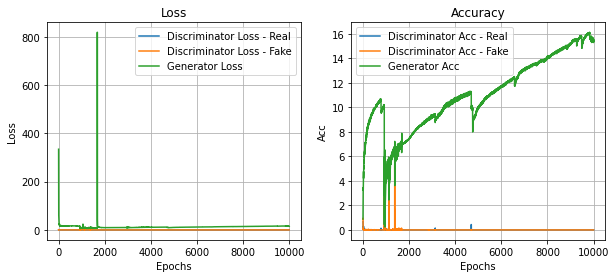

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 9ms/step
7501 [D loss: 0.000015] [G loss: 10.866594] [fake: 0.000022, real: 0.000009]    [D acc: 0.000015] [G acc: 10.786640]
8/8 [==============================] - 0s 10ms/step
7502 [D loss: 0.000017] [G loss: 10.823052] [fake: 0.000024, real: 0.000010]    [D acc: 0.000017] [G acc: 10.753803]
8/8 [==============================] - 0s 8ms/step
7503 [D loss: 0.000015] [G loss: 10.827701] [fake: 0.000022, real: 0.000009]    [D acc: 0.000015] [G acc: 10.772324]
8/8 [==============================] - 0s 9ms/step
7504 [D loss: 0.000018] [G loss: 10.796110] [fake: 0.000026, real: 0.000010]    [D acc: 0.000018] [G acc: 10.741102]
8/8 [==============================] - 0s 9ms/step
7505 [D loss: 0.000015] [G loss: 10.837600] [fake: 0.000022, real: 0.000008]    [D acc: 0.000015] [G acc: 10.786692]
8/8 [==============================] - 0s 10ms/step
7506 [D loss: 0.000014] [G loss: 10.842193] [fake: 0.000

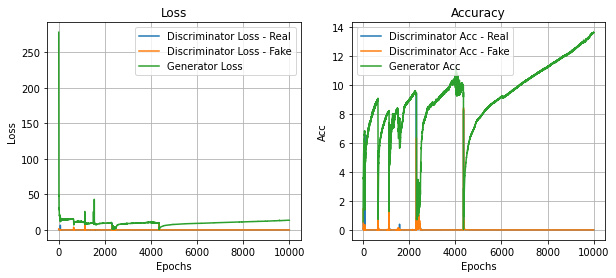

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 8ms/step
7501 [D loss: 0.000008] [G loss: 11.931692] [fake: 0.000011, real: 0.000004]    [D acc: 0.000008] [G acc: 11.885004]
8/8 [==============================] - 0s 9ms/step
7502 [D loss: 0.000007] [G loss: 11.956668] [fake: 0.000011, real: 0.000004]    [D acc: 0.000007] [G acc: 11.913397]
8/8 [==============================] - 0s 10ms/step
7503 [D loss: 0.000009] [G loss: 11.908816] [fake: 0.000013, real: 0.000005]    [D acc: 0.000009] [G acc: 11.848454]
8/8 [==============================] - 0s 10ms/step
7504 [D loss: 0.000006] [G loss: 11.996607] [fake: 0.000009, real: 0.000003]    [D acc: 0.000006] [G acc: 11.952482]
8/8 [==============================] - 0s 9ms/step
7505 [D loss: 0.000007] [G loss: 11.971083] [fake: 0.000011, real: 0.000004]    [D acc: 0.000007] [G acc: 11.922417]
8/8 [==============================] - 0s 9ms/step
7506 [D loss: 0.000012] [G loss: 11.867431] [fake: 0.000

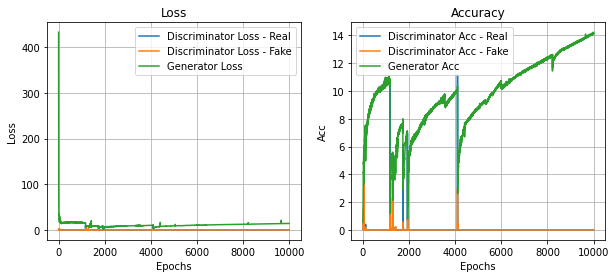

Exec time: 65.91875260273615 min
Exec proc time: 59.655624195566666 min


In [ ]:
seeds = [11, 12, 13]
for seed in seeds:
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

    train_file = 'data/breadcrumbs/train.csv'
    test_file = 'data/breadcrumbs/test.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    # Randomization (user permutation)
    df_train = permute_uid(df_train, seed)

    train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajgan(df_train, df_test)

    # Train
    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    start = time.time()
    start_proc = time.process_time()

    gan.train(train_x, epochs=10000, sample_interval=100, save_path='further_exp/training_params/breadcrumbs_s'+str(seed))

    end = time.time()
    end_proc = time.process_time()

    print('Exec time:', (end-start)/60, 'min')
    print('Exec proc time:', (end_proc-start_proc)/60, 'min')


In [ ]:
seeds = [11, 12, 13]
for seed in seeds:
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    gan.generator.load_weights('further_exp/training_params/breadcrumbs_s'+str(seed)+'/G_model_10000.h5')

    # Generate synthetic train and test 
    noise = np.random.normal(0, 1, (train_x[0].shape[0], 64))
    train_real = []
    train_real = train_x[:4]
    train_real.append(noise)

    start = time.time()
    start_proc = time.process_time()
    train_gen = gan.generator.predict(train_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic trainset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's', end='\n\n')

    noise = np.random.normal(0, 1, (test_x[0].shape[0], 64))
    test_real = []
    test_real = test_x[:4]
    test_real.append(noise)

    start = time.time()
    start_proc = time.process_time()
    test_gen = gan.generator.predict(test_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic testset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's')

    # Quick Check
    voc = ['day', 'hour', 'poi']
    for i in range(1,len(test_gen)):
        print(np.unique(np.argmax(test_gen[i], axis=2)).shape[0], ' out of ', vocab_sizes[voc[i-1]])

    # Postproc and save
    df_train_gen = postproc_trajgan(train_gen, df_train)
    df_test_gen = postproc_trajgan(test_gen, df_test)
    df_train_gen.to_csv('further_exp/data/breadcrumbs/train_synth_s'+str(seed)+'.csv', index=False)
    df_test_gen.to_csv('further_exp/data/breadcrumbs/test_synth_s'+str(seed)+'.csv', index=False)

    print(end='\n\n\n')

25/25 [==============================] - 1s 7ms/step
Generating synthetic trainset
Exec time: 0.8043053150177002 s
Exec proc time: 0.7562053669989837 s

10/10 [==============================] - 0s 7ms/step
Generating synthetic testset
Exec time: 0.16112923622131348 s
Exec proc time: 0.1731544029989891 s
7  out of  7
18  out of  18
34  out of  36



25/25 [==============================] - 1s 7ms/step
Generating synthetic trainset
Exec time: 0.7436814308166504 s
Exec proc time: 0.7504673249986809 s

10/10 [==============================] - 0s 6ms/step
Generating synthetic testset
Exec time: 0.15207314491271973 s
Exec proc time: 0.16514586800076358 s
7  out of  7
18  out of  18
33  out of  36



25/25 [==============================] - 1s 7ms/step
Generating synthetic trainset
Exec time: 0.7825653553009033 s
Exec proc time: 0.735469605999242 s

10/10 [==============================] - 0s 6ms/step
Generating synthetic testset
Exec time: 0.20377802848815918 s
Exec proc time: 0.162943551998

## Experiments

In [ ]:
seeds = [11,12,13]
df_all = []
for seed in seeds:
    # Real
    test_file = 'data/breadcrumbs/test.csv'
    df_test = pd.read_csv(test_file)
    # df_test = permute_uid(df_test, 13)

    # Synth
    test_file = 'further_exp/data/breadcrumbs/test_synth_s'+str(seed)+'.csv'
    df_test_gen = pd.read_csv(test_file)

    # Setup for plots
    df_test_gen['source'] = ['generated' for i in range(df_test_gen.shape[0])]
    df_test['source'] = ['real' for i in range(df_test.shape[0])]
    df_all.append(pd.concat([df_test, df_test_gen], ignore_index=True))

### Spatial

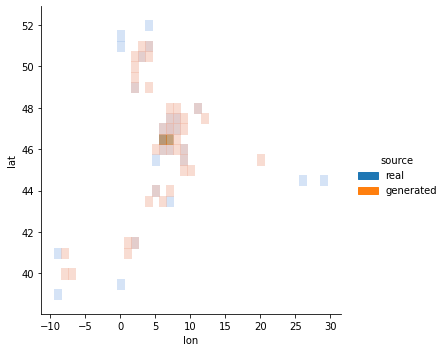

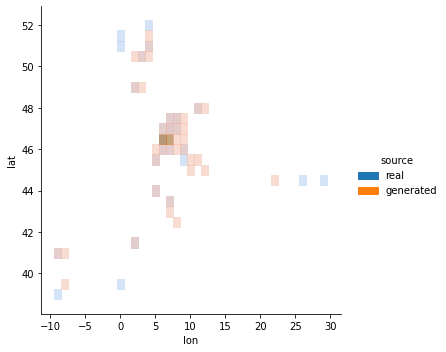

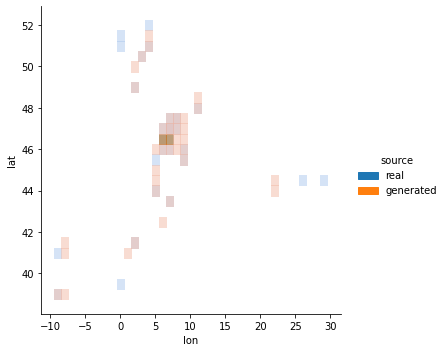

In [ ]:
for df in df_all:
    sns.displot(data=df, x='lon', y='lat', hue='source', binwidth=(1, .5), alpha=.5)

### Temporal

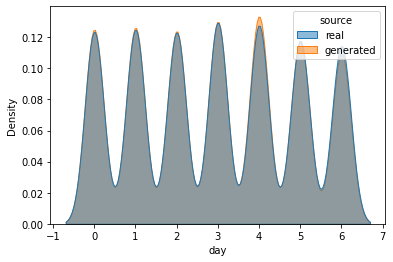

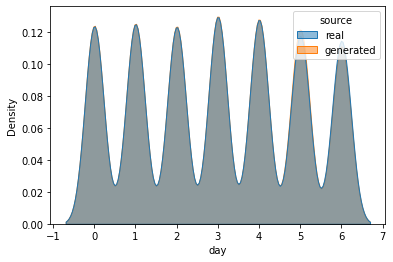

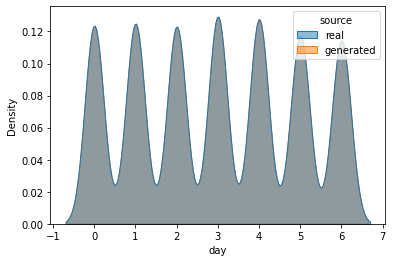

In [ ]:
for df in df_all:
    plt.figure()
    sns.kdeplot(data=df, x="day", hue="source", fill=True, alpha=.5,)
    print()

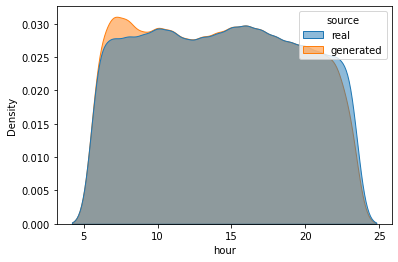

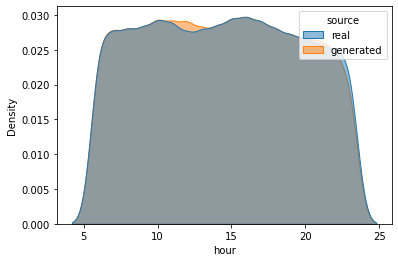

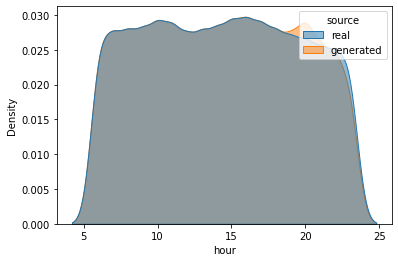

In [ ]:
for df in df_all:
    plt.figure()
    sns.kdeplot(data=df, x="hour", hue="source", fill=True, alpha=.5,)

In [ ]:
from scipy import stats
for df in df_all:
    print('Pearson coefficient')
    print(' day: ',stats.pearsonr(df[df['source']=='real'].day, 
                                  df[df['source']=='generated'].day))
    
    print('hour: ',stats.pearsonr(df[df['source']=='real'].hour, 
                                  df[df['source']=='generated'].hour))
    print()


Pearson coefficient
 day:  (0.9945603468145541, 0.0)
hour:  (0.9373062071523552, 0.0)

Pearson coefficient
 day:  (0.9994180435573607, 0.0)
hour:  (0.9892855132045504, 0.0)

Pearson coefficient
 day:  (0.9997546097532186, 0.0)
hour:  (0.9987969671573855, 0.0)



### Categorical

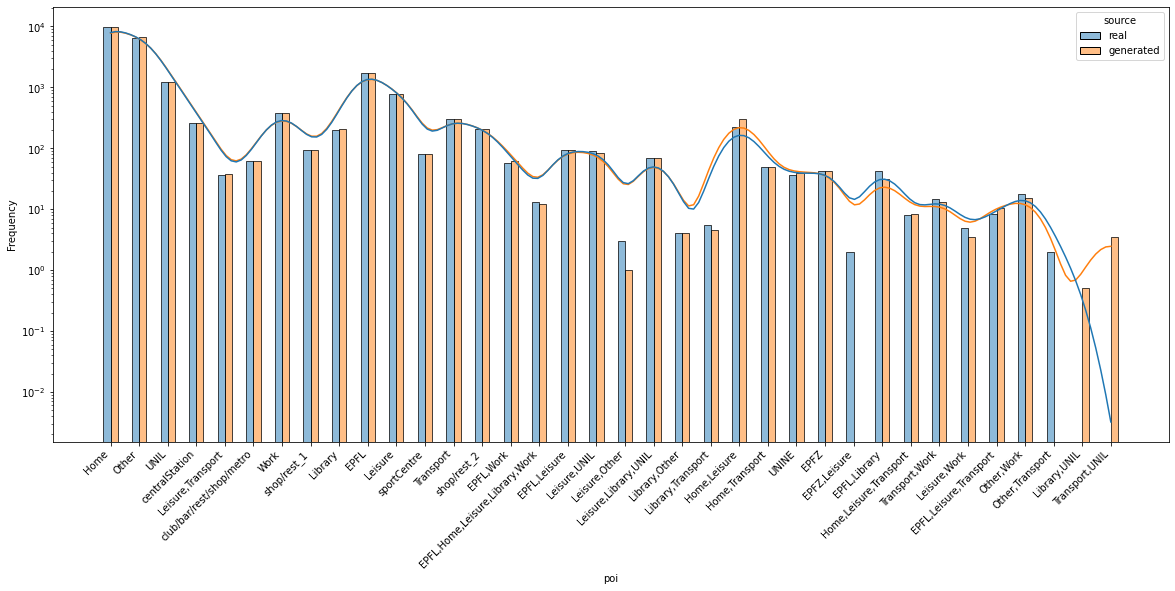

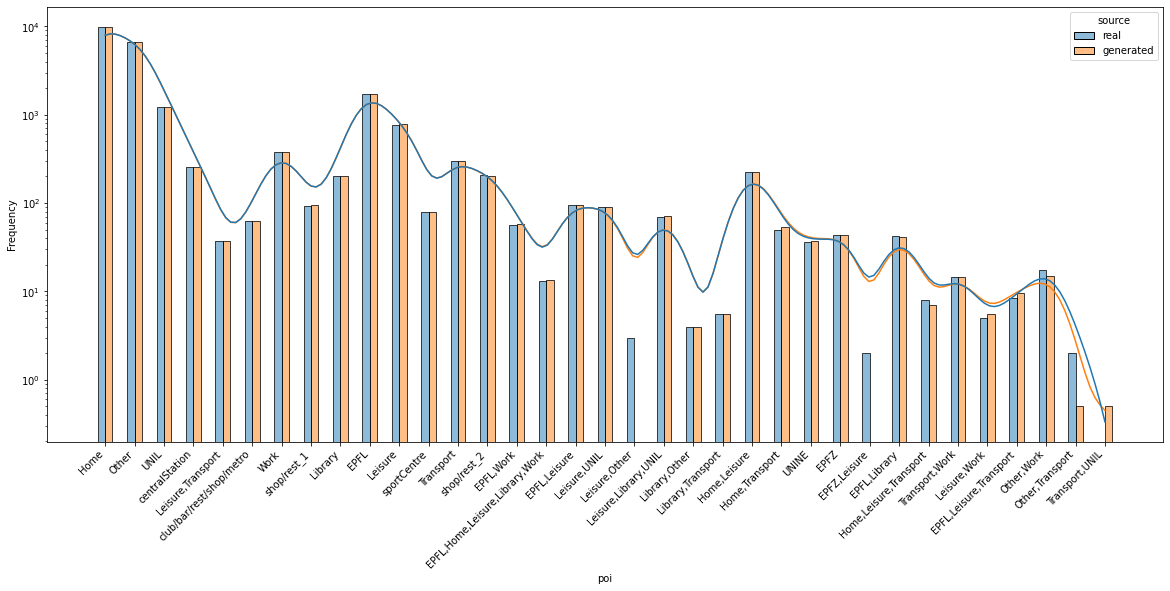

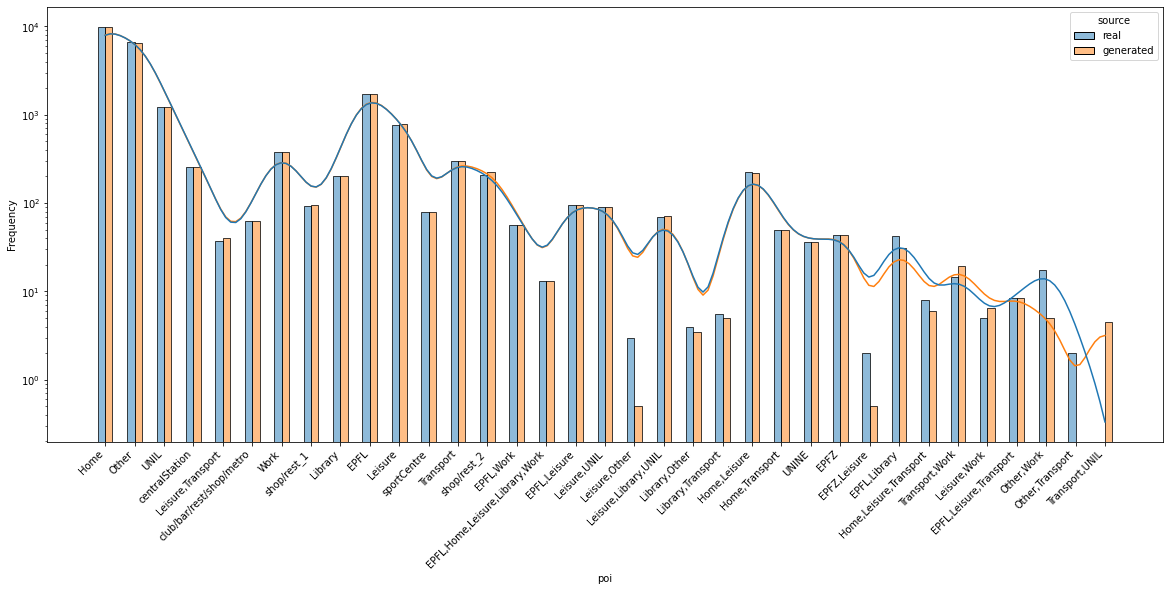

In [ ]:
import seaborn as sns
for df in df_all:
    plt.figure(figsize=(20,8))
    axs = sns.histplot(data=df,
                x='poi', 
                stat='frequency', 
                multiple='dodge', 
                hue='source',
                shrink=.5,
                kde=True)
    plt.xticks(rotation=45, ha="right")
    axs.set_yscale('log')

# Foursquare (categorical POIs)

## Train

In [ ]:
seeds = [11, 12, 13]
for seed in seeds:
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

    train_file = 'data/foursquare/train_cat.csv'
    test_file = 'data/foursquare/test_cat.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    # Randomization (user permutation)
    df = permute_uid(df_train, seed)

    train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajgan(df_train, df_test)

    # Train
    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    start = time.time()
    start_proc = time.process_time()

    gan.train(train_x, epochs=1000, save_path='further_exp/training_params/foursquare_s'+str(seed))

    end = time.time()
    end_proc = time.process_time()

    print('Training')
    print('Exec time:', (end-start)/60, 'min')
    print('Exec proc time:', (end_proc-start_proc)/60, 'min')

313663
313663
313663


In [ ]:
seeds = [11, 12, 13]
for seed in seeds:
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    gan.generator.load_weights('further_exp/training_params/foursquare_s'+str(seed)+'/G_model_1000.h5')

    # Generate synthetic train and test 
    noise = np.random.normal(0, 1, (train_x[0].shape[0], 64))
    train_real = []
    train_real = train_x[:4]
    train_real.append(noise)

    start = time.time()
    start_proc = time.process_time()
    train_gen = gan.generator.predict(train_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic trainset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's', end='\n\n')

    noise = np.random.normal(0, 1, (test_x[0].shape[0], 64))
    test_real = []
    test_real = test_x[:4]
    test_real.append(noise)

    start = time.time()
    start_proc = time.process_time()
    test_gen = gan.generator.predict(test_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic testset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's')

    # Quick check
    voc = ['day', 'hour', 'poi']
    for i in range(1,len(test_gen)):
        print(np.unique(np.argmax(test_gen[i], axis=2)).shape[0], ' out of ', vocab_sizes[voc[i-1]])

    # Postproc and save
    df_train_gen = postproc_trajgan(train_gen, df_train)
    df_test_gen = postproc_trajgan(test_gen, df_test)
    df_train_gen.to_csv('further_exp/data/foursquare/train_cat_synth_s'+str(seed)+'.csv', index=False)
    df_test_gen.to_csv('further_exp/data/foursquare/test_cat_synth_s'+str(seed)+'.csv', index=False)

    print(end='\n\n\n')
    

65/65 [==============================] - 1s 5ms/step
Generating synthetic trainset
Exec time: 1.0746650695800781 s
Exec proc time: 0.9604204320003191 s

33/33 [==============================] - 0s 5ms/step
Generating synthetic testset
Exec time: 0.38236403465270996 s
Exec proc time: 0.3295249480001985 s
7  out of  7
24  out of  24
10  out of  10
65/65 [==============================] - 1s 5ms/step
Generating synthetic trainset
Exec time: 1.1002798080444336 s
Exec proc time: 0.9880744000001869 s

33/33 [==============================] - 0s 5ms/step
Generating synthetic testset
Exec time: 0.36574721336364746 s
Exec proc time: 0.3191199989996676 s
7  out of  7
24  out of  24
10  out of  10
65/65 [==============================] - 1s 5ms/step
Generating synthetic trainset
Exec time: 0.8968815803527832 s
Exec proc time: 0.944322388999808 s

33/33 [==============================] - 0s 5ms/step
Generating synthetic testset
Exec time: 0.36536455154418945 s
Exec proc time: 0.30457768500036764 s

## Experiments

In [ ]:
seeds = [11,12,13]
df_all = []
for seed in seeds:
    # Real
    test_file = 'data/foursquare/test_cat.csv'
    df_test = pd.read_csv(test_file)
    # df_test = permute_uid(df_test, 13)

    # Synth
    test_file = 'further_exp/data/foursquare/test_cat_synth_s'+str(seed)+'.csv'
    df_test_gen = pd.read_csv(test_file)

    # Setup for plots
    df_test_gen['source'] = ['generated' for i in range(df_test_gen.shape[0])]
    df_test['source'] = ['real' for i in range(df_test.shape[0])]
    df_all.append(pd.concat([df_test, df_test_gen], ignore_index=True))

### Spatial

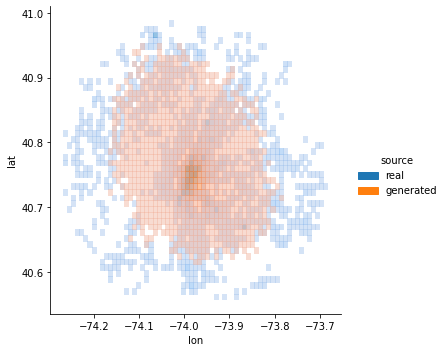

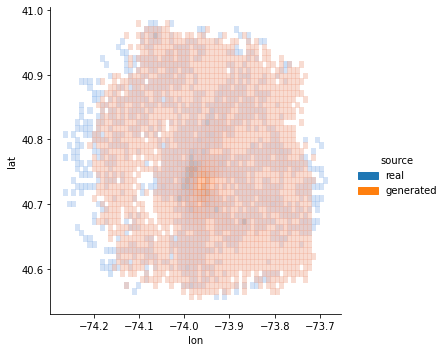

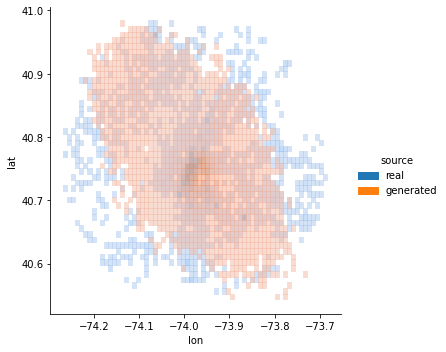

In [ ]:
for df in df_all:
    sns.displot(data=df, x='lon', y='lat', hue='source', binwidth=(0.009, 0.009), alpha=.5)

### Temporal

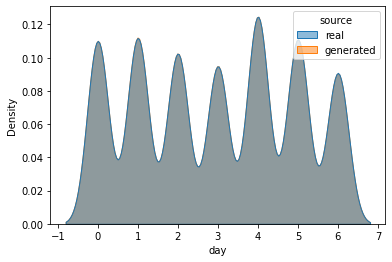

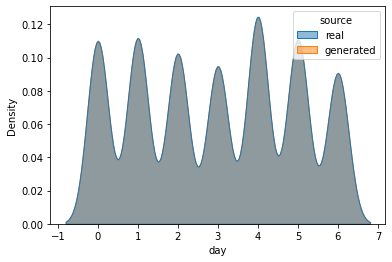

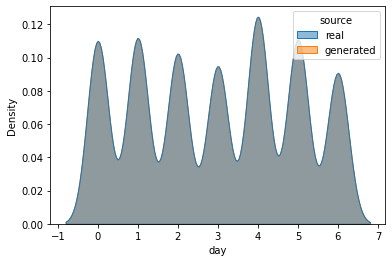

In [ ]:
for df in df_all:
    plt.figure()
    sns.kdeplot(data=df, x="day", hue="source", fill=True, alpha=.5,)
    print()

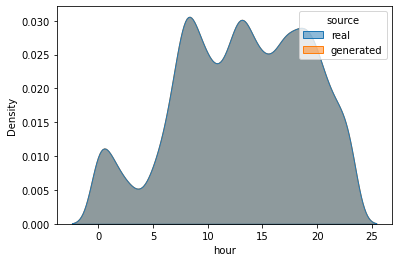

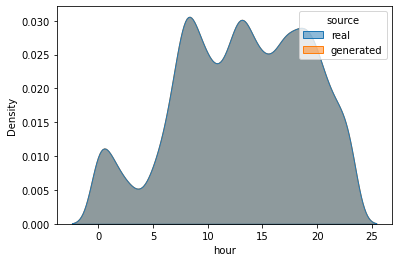

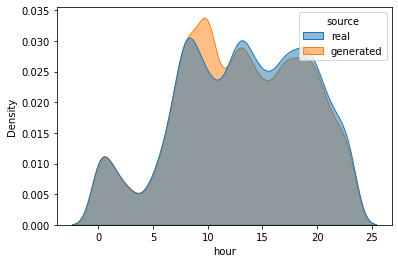

In [ ]:
for df in df_all:
    plt.figure()
    sns.kdeplot(data=df, x="hour", hue="source", fill=True, alpha=.5,)

In [ ]:
from scipy import stats
for df in df_all:
    print('Pearson coefficient')
    print(' day: ',stats.pearsonr(df[df['source']=='real'].day, 
                                  df[df['source']=='generated'].day))
    
    print('hour: ',stats.pearsonr(df[df['source']=='real'].hour, 
                                  df[df['source']=='generated'].hour))
    print()


Pearson coefficient
 day:  (0.9990851879188164, 0.0)
hour:  (1.0, 0.0)

Pearson coefficient
 day:  (0.9993786350669672, 0.0)
hour:  (1.0, 0.0)

Pearson coefficient
 day:  (0.9999079435586102, 0.0)
hour:  (0.9698462101001067, 0.0)



### Categorical

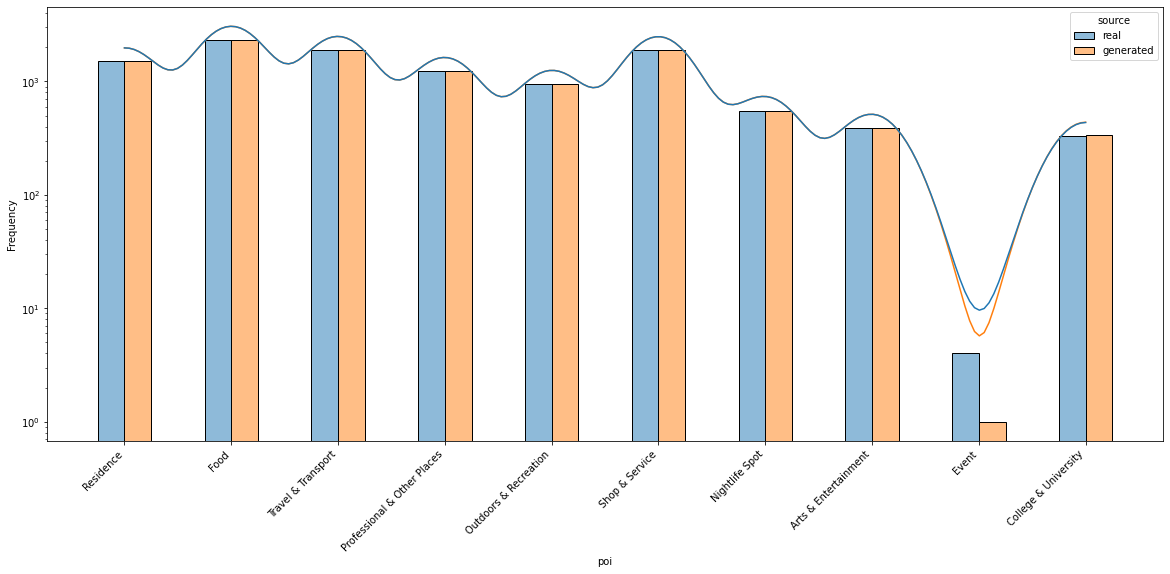

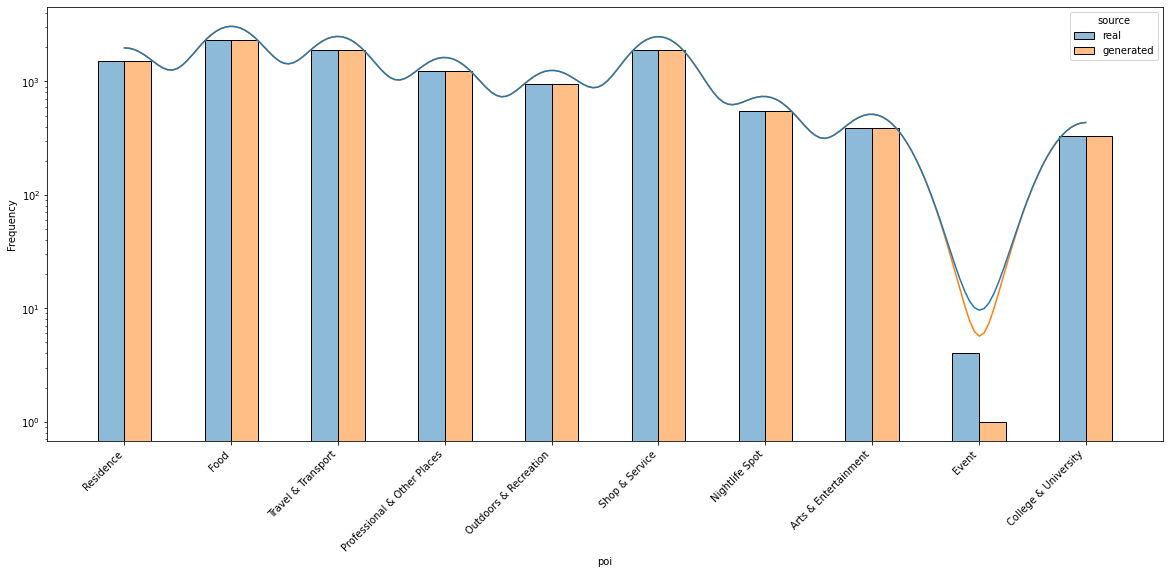

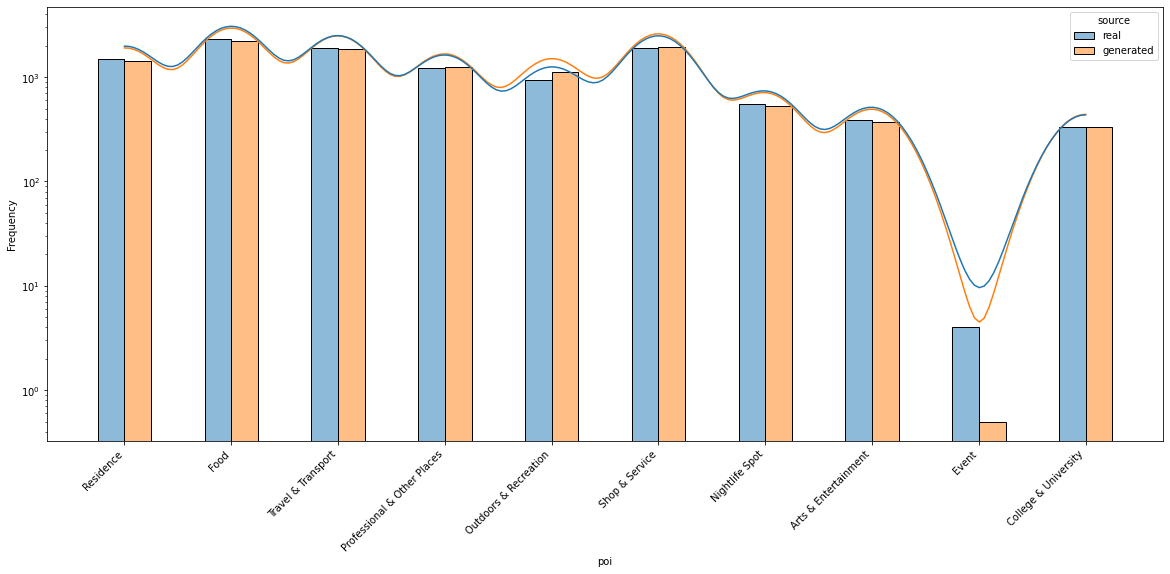

In [ ]:
import seaborn as sns
for df in df_all:
    plt.figure(figsize=(20,8))
    axs = sns.histplot(data=df,
                x='poi', 
                stat='frequency', 
                multiple='dodge', 
                hue='source',
                shrink=.5,
                kde=True)
    plt.xticks(rotation=45, ha="right")
    axs.set_yscale('log')

# Breadcrumbs % Data

## Train


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 7ms/step
7501 [D loss: 0.000069] [G loss: 13.411281] [fake: 0.000076, real: 0.000062]    [D acc: 0.000069] [G acc: 13.296208]
8/8 [==============================] - 0s 7ms/step
7502 [D loss: 0.000028] [G loss: 13.565814] [fake: 0.000032, real: 0.000025]    [D acc: 0.000028] [G acc: 13.462983]
8/8 [==============================] - 0s 7ms/step
7503 [D loss: 0.000028] [G loss: 13.612526] [fake: 0.000031, real: 0.000025]    [D acc: 0.000028] [G acc: 13.504101]
8/8 [==============================] - 0s 7ms/step
7504 [D loss: 0.000028] [G loss: 13.596232] [fake: 0.000031, real: 0.000025]    [D acc: 0.000028] [G acc: 13.477554]
8/8 [==============================] - 0s 8ms/step
7505 [D loss: 0.000028] [G loss: 13.570613] [fake: 0.000031, real: 0.000025]    [D acc: 0.000028] [G acc: 13.433630]
8/8 [==============================] - 0s 6ms/step
7506 [D loss: 0.000082] [G loss: 13.470897] [fake: 0.00009

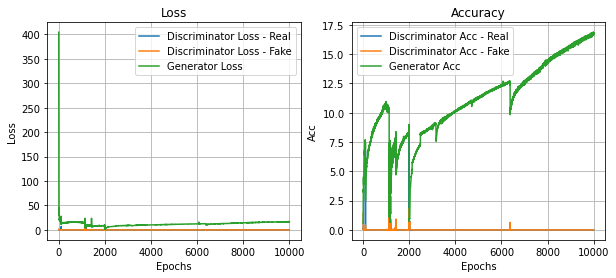

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 6ms/step
7501 [D loss: 0.000125] [G loss: 10.175591] [fake: 0.000090, real: 0.000159]    [D acc: 0.000125] [G acc: 10.050642]
8/8 [==============================] - 0s 7ms/step
7502 [D loss: 0.000169] [G loss: 10.162503] [fake: 0.000115, real: 0.000223]    [D acc: 0.000169] [G acc: 10.020889]
8/8 [==============================] - 0s 7ms/step
7503 [D loss: 0.000078] [G loss: 10.203122] [fake: 0.000064, real: 0.000092]    [D acc: 0.000078] [G acc: 10.091697]
8/8 [==============================] - 0s 7ms/step
7504 [D loss: 0.000129] [G loss: 10.143466] [fake: 0.000088, real: 0.000170]    [D acc: 0.000129] [G acc: 10.001529]
8/8 [==============================] - 0s 7ms/step
7505 [D loss: 0.000106] [G loss: 10.175211] [fake: 0.000075, real: 0.000137]    [D acc: 0.000106] [G acc: 10.055181]
8/8 [==============================] - 0s 7ms/step
7506 [D loss: 0.000144] [G loss: 10.225365] [fake: 0.00009

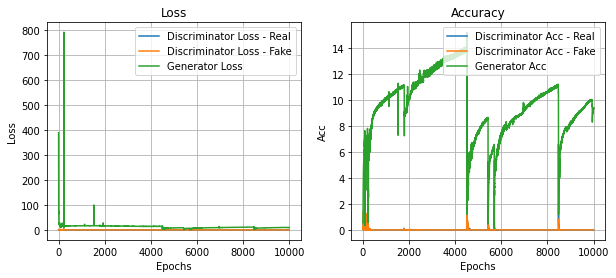

Training
Exec time: 57.577808153629306 min
Exec proc time: 60.76657538916667 min


In [ ]:
# Percentage
percentages = [50, 30]
for p in percentages:

    train_file = 'data/breadcrumbs/train.csv'
    test_file = 'data/breadcrumbs/test.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    df_train = traj_percentage(df_train, p)
    # print(df_train.size)
    train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajgan(df_train, df_test)

    np.random.seed(13)
    python_random.seed(13)
    tf.random.set_seed(13)

    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    start = time.time()
    start_proc = time.process_time()

    gan.train(train_x, epochs=10000, sample_interval=1000, save_path='further_exp/training_params/breadcrumbs'+str(p))

    end = time.time()
    end_proc = time.process_time()

    print('Training')
    print('Exec time:', (end-start)/60, 'min')
    print('Exec proc time:', (end_proc-start_proc)/60, 'min')

## Save

In [ ]:
# Percentage
percentages = [50, 30]
for p in percentages:

    np.random.seed(13)
    python_random.seed(13)
    tf.random.set_seed(13)

    print('## '+str(p)+'% of data ##')

    train_file = 'data/breadcrumbs/train.csv'
    test_file = 'data/breadcrumbs/test.csv'
    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    df_train = traj_percentage(df_train, p)

    train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajgan(df_train, df_test)

    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    gan.generator.load_weights('further_exp/training_params/breadcrumbs'+str(p)+'/G_model_10000.h5')

    # Generate synthetic train and test 
    noise = np.random.normal(0, 1, (train_x[0].shape[0], 64))
    train_real = []
    train_real = train_x[:4]
    train_real.append(noise)
    start = time.time()
    start_proc = time.process_time()
    train_gen = gan.generator.predict(train_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic trainset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's', end='\n\n')

    noise = np.random.normal(0, 1, (test_x[0].shape[0], 64))
    test_real = []
    test_real = test_x[:4]
    test_real.append(noise)

    start = time.time()
    start_proc = time.process_time()
    test_gen = gan.generator.predict(test_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic testset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's')

    # Quick Check
    voc = ['day', 'hour', 'poi']
    for i in range(1,len(test_gen)):
        print(np.unique(np.argmax(test_gen[i], axis=2)).shape[0], ' out of ', vocab_sizes[voc[i-1]])

    df_train_gen = postproc_trajgan(train_gen, df_train)
    df_test_gen = postproc_trajgan(test_gen, df_test)

    # Save synth data
    df_train_gen.to_csv('further_exp/data/breadcrumbs/train_synth_'+str(p)+'.csv', index=False)
    df_test_gen.to_csv('further_exp/data/breadcrumbs/test_synth_'+str(p)+'.csv', index=False)
    print()

## 50% of data ##
Trajectories:   709
Labels:         80
Train size:     0.5486600846262342
Test size:      0.4513399153737659
x_train shape:  (5, 389)
x_test shape:   (5, 320)
13/13 [==============================] - 1s 7ms/step
Generating synthetic trainset
Exec time: 0.6293396949768066 s
Exec proc time: 0.659286117001102 s

10/10 [==============================] - 0s 8ms/step
Generating synthetic testset
Exec time: 0.15666556358337402 s
Exec proc time: 0.18301560200052336 s
7  out of  7
18  out of  18
34  out of  36

## 30% of data ##
Trajectories:   549
Labels:         80
Train size:     0.41712204007285975
Test size:      0.5828779599271403
x_train shape:  (5, 229)
x_test shape:   (5, 320)
8/8 [==============================] - 0s 7ms/step
Generating synthetic trainset
Exec time: 0.5631103515625 s
Exec proc time: 0.5860371430007945 s

10/10 [==============================] - 0s 7ms/step
Generating synthetic testset
Exec time: 0.14857172966003418 s
Exec proc time: 0.169194489000801

# Foursquare % Data

## Train

Trajectories:   1988
Labels:         193
Train size:     0.4834004024144869
Test size:      0.5165995975855131
x_train shape:  (5, 961)
x_test shape:   (5, 1027)
8/8 [==============================] - 0s 6ms/step
1 [D loss: 0.743364] [G loss: 8.543591] [fake: 0.713573, real: 0.773156]    [D acc: 0.743364] [G acc: 0.715158]
8/8 [==============================] - 0s 5ms/step
2 [D loss: 0.670814] [G loss: 8.381493] [fake: 0.722597, real: 0.619031]    [D acc: 0.670814] [G acc: 0.695696]
8/8 [==============================] - 0s 5ms/step
3 [D loss: 0.651857] [G loss: 8.259892] [fake: 0.753735, real: 0.549978]    [D acc: 0.651857] [G acc: 0.676426]
8/8 [==============================] - 0s 5ms/step
4 [D loss: 0.607338] [G loss: 8.203002] [fake: 0.742261, real: 0.472415]    [D acc: 0.607338] [G acc: 0.701336]
8/8 [==============================] - 0s 5ms/step
5 [D loss: 0.553397] [G loss: 8.131463] [fake: 0.708353, real: 0.398440]    [D acc: 0.553397] [G acc: 0.750700]
8/8 [==================

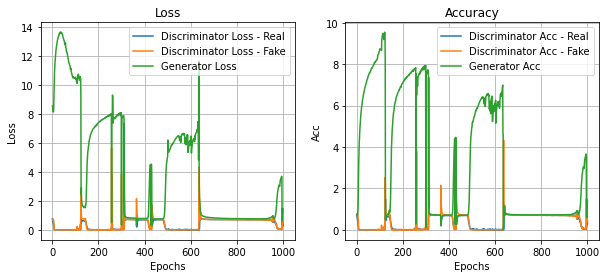

Training
Exec time: 5.080410460631053 min
Exec proc time: 5.334280957516664 min
Trajectories:   1574
Labels:         193
Train size:     0.3475222363405337
Test size:      0.6524777636594663
x_train shape:  (5, 547)
x_test shape:   (5, 1027)
8/8 [==============================] - 0s 6ms/step
1 [D loss: 0.745764] [G loss: 8.540173] [fake: 0.715298, real: 0.776230]    [D acc: 0.745764] [G acc: 0.713453]
8/8 [==============================] - 0s 5ms/step
2 [D loss: 0.672070] [G loss: 8.359434] [fake: 0.720259, real: 0.623881]    [D acc: 0.672070] [G acc: 0.699035]
8/8 [==============================] - 0s 5ms/step
3 [D loss: 0.647864] [G loss: 8.270597] [fake: 0.754205, real: 0.541523]    [D acc: 0.647864] [G acc: 0.685987]
8/8 [==============================] - 0s 5ms/step
4 [D loss: 0.607644] [G loss: 8.220150] [fake: 0.740926, real: 0.474362]    [D acc: 0.607644] [G acc: 0.702334]
8/8 [==============================] - 0s 5ms/step
5 [D loss: 0.548197] [G loss: 8.130195] [fake: 0.702663

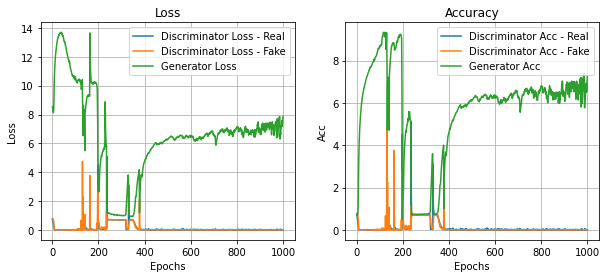

Training
Exec time: 5.140234478314718 min
Exec proc time: 5.383859196149994 min


In [ ]:
# Percentage
percentages = [50, 30]
for p in percentages:

    train_file = 'data/foursquare/train_cat.csv'
    test_file = 'data/foursquare/test_cat.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    df_train = traj_percentage(df_train, p) 
    # print(df_train.shape)
    train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajgan(df_train, df_test)


    np.random.seed(13)
    python_random.seed(13)
    tf.random.set_seed(13)

    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)
    
    start = time.time()
    start_proc = time.process_time()

    gan.train(train_x, epochs=1000, sample_interval=100, save_path='further_exp/training_params/foursquare'+str(p))

    end = time.time()
    end_proc = time.process_time()

    print('Training')
    print('Exec time:', (end-start)/60, 'min')
    print('Exec proc time:', (end_proc-start_proc)/60, 'min')

## Save

In [ ]:
# Percentage
percentages = [50, 30]
for p in percentages:

    np.random.seed(13)
    python_random.seed(13)
    tf.random.set_seed(13)

    print('## '+str(p)+'% of data ##')

    train_file = 'data/foursquare/train_cat.csv'
    test_file = 'data/foursquare/test_cat.csv'
    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    df_train = traj_percentage(df_train, p)

    train_x, test_x, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajgan(df_train, df_test)

    gan = LSTM_TrajGAN(64, vocab_sizes, vocab_centroid)

    gan.generator.load_weights('further_exp/training_params/foursquare'+str(p)+'/G_model_1000.h5')

    # Generate synthetic train and test 
    noise = np.random.normal(0, 1, (train_x[0].shape[0], 64))
    train_real = []
    train_real = train_x[:4]
    train_real.append(noise)
    start = time.time()
    start_proc = time.process_time()
    train_gen = gan.generator.predict(train_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic trainset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's', end='\n\n')

    noise = np.random.normal(0, 1, (test_x[0].shape[0], 64))
    test_real = []
    test_real = test_x[:4]
    test_real.append(noise)

    start = time.time()
    start_proc = time.process_time()
    test_gen = gan.generator.predict(test_real)
    end = time.time()
    end_proc = time.process_time()
    print('Generating synthetic testset')
    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's')

    # Quick Check
    voc = ['day', 'hour', 'poi']
    for i in range(1,len(test_gen)):
        print(np.unique(np.argmax(test_gen[i], axis=2)).shape[0], ' out of ', vocab_sizes[voc[i-1]])

    df_train_gen = postproc_trajgan(train_gen, df_train)
    df_test_gen = postproc_trajgan(test_gen, df_test)

    # Save synth data
    df_train_gen.to_csv('further_exp/data/foursquare/train_cat_synth_'+str(p)+'.csv', index=False)
    df_test_gen.to_csv('further_exp/data/foursquare/test_cat_synth_'+str(p)+'.csv', index=False)
    print()

## 50% of data ##
Trajectories:   1988
Labels:         193
Train size:     0.4834004024144869
Test size:      0.5165995975855131
x_train shape:  (5, 961)
x_test shape:   (5, 1027)
31/31 [==============================] - 1s 6ms/step
Generating synthetic trainset
Exec time: 0.6759717464447021 s
Exec proc time: 0.7351098250001087 s

33/33 [==============================] - 0s 5ms/step
Generating synthetic testset
Exec time: 0.2768104076385498 s
Exec proc time: 0.3484784359989135 s
7  out of  7
24  out of  24
9  out of  10

## 30% of data ##
Trajectories:   1574
Labels:         193
Train size:     0.3475222363405337
Test size:      0.6524777636594663
x_train shape:  (5, 547)
x_test shape:   (5, 1027)
18/18 [==============================] - 1s 5ms/step
Generating synthetic trainset
Exec time: 0.6199913024902344 s
Exec proc time: 0.6573354280008061 s

33/33 [==============================] - 0s 5ms/step
Generating synthetic testset
Exec time: 0.27675318717956543 s
Exec proc time: 0.3345409